In [1]:
import json
from transformers import AutoTokenizer, AutoConfig
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
question = "Summarize the meeting transcrip. Summarize each item in two sentences."
PROMPT_DICT = {
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_no_input_llama2": (
        "<s>[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} [/INST]"
    ),
    "prompt_llama2": "[INST]{instruction}[/INST]"
}
prompt_no_input = PROMPT_DICT["prompt_llama2"]

In [3]:
model_name = "Yukang/LongAlpaca-7B"
cache_dir = "../cache"
context_size = 32768

In [4]:
config = AutoConfig.from_pretrained(model_name, cache_dir=cache_dir)

orig_ctx_len = getattr(config, "max_position_embeddings", None)
if orig_ctx_len and context_size > orig_ctx_len:
    scaling_factor = float(math.ceil(context_size / orig_ctx_len))
    config.rope_scaling = {"type": "linear", "factor": scaling_factor}

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    model_max_length=context_size if context_size > orig_ctx_len else orig_ctx_len,
    padding_side="right",
    use_fast=False,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
def num_tokens_from_string(string):
    return len(tokenizer.encode(string))

def calculate_length(path):
    with open(path, 'r') as f:
        data = json.load(f)
    source_lengths = []
    target_lengths = []
    for meeting in tqdm(data):
        source_lengths.append(num_tokens_from_string(prompt_no_input.format_map({"instruction": meeting['source'] + "\n%s"%question})))
        target_lengths.append(num_tokens_from_string(meeting['summary']))
    return source_lengths, target_lengths

In [10]:
def min_max_avg(numbers):
    min_val = min(numbers)
    max_val = max(numbers)
    avg_val = sum(numbers) / len(numbers)
    return min_val, max_val, avg_val

In [11]:
def plot_lengths(data0, data1=None):
    plt.hist(data0, bins=100, alpha=0.5, color='blue', label='Source')
    if data1 is not None:
        plt.hist(data1, bins=100, alpha=0.5, color='red', label='Target')
    plt.show()

100%|██████████| 1587/1587 [01:37<00:00, 16.22it/s]


train-source: min=26, max=15959, avg=9099.987397605544
train-target: min=1, max=2461, avg=390.4026465028355


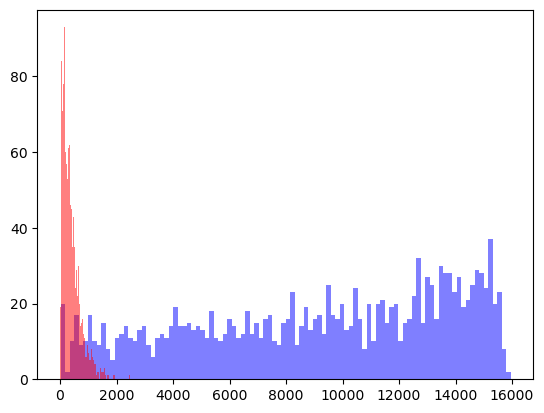

100%|██████████| 198/198 [00:11<00:00, 16.99it/s]


validation-source: min=26, max=15807, avg=8871.141414141413
validation-target: min=1, max=1746, avg=374.85353535353534


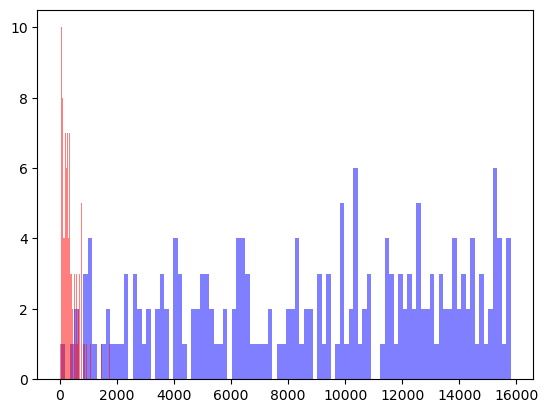

100%|██████████| 199/199 [00:12<00:00, 16.39it/s]


test-source: min=26, max=15937, avg=9207.869346733669
test-target: min=1, max=1768, avg=386.57286432160805


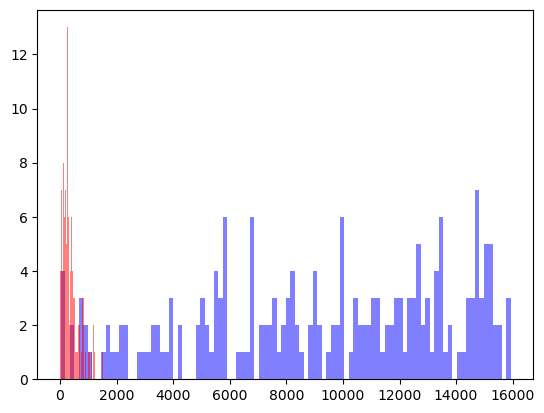

In [12]:
tasks = ['train', 'validation', 'test']
for task in tasks:
    source_lengths, target_lengths = calculate_length('{}_text.json'.format(task))
    source_min, source_max, source_avg = min_max_avg(source_lengths)
    print(f'{task}-source: min={source_min}, max={source_max}, avg={source_avg}')
    target_min, target_max, target_avg = min_max_avg(target_lengths)
    print(f'{task}-target: min={target_min}, max={target_max}, avg={target_avg}')
    plot_lengths(source_lengths, target_lengths)

In [23]:
def show_stat(stat):
    for task in stat:
        print(f'==================== {task} ====================')
        source_lengths, target_lengths = stat[task]
        total_lengths = [source_lengths[i] + target_lengths[i] for i in range(len(source_lengths))]

        # source_min, source_max, source_avg = min_max_avg(source_lengths)
        # print(f'{task}-source: min={source_min}, max={source_max}, avg={source_avg}')

        # target_min, target_max, target_avg = min_max_avg(target_lengths)
        # print(f'{task}-target: min={target_min}, max={target_max}, avg={target_avg}')

        total_min, total_max, total_avg = min_max_avg(total_lengths)
        print(f'{task}-total: min={total_min}, max={total_max}, avg={total_avg}')
        
        length_4k = 0
        length_8k = 0
        length_16k = 0
        length_32k = 0
        length_above = 0
        for l in total_lengths:
            if l <= 4000:
                length_4k += 1
            elif l <= 8000:
                length_8k += 1
            elif l <= 16000:
                length_16k += 1
            elif l <= 32000:
                length_32k += 1
            else:
                length_above += 1
        print(f'{task}-total: 4k={length_4k}, 8k={length_8k}, 16k={length_16k}, 32k={length_32k}, above={length_above}')

        # plot_lengths(source_lengths, target_lengths)
        # plot_lengths(total_lengths)

In [18]:
stats = dict()
for task in ['test', 'validation', 'train']:
    path = f'{task}_segment.json'
    stats[task] = calculate_length(path)

100%|██████████| 5169/5169 [05:49<00:00, 14.78it/s]


In [24]:
show_stat(stats)

==================== test ====================
test-total: min=236, max=96605, avg=4205.548723897912
test-total: 4k=631, 8k=123, 16k=69, 32k=27, above=12
==================== validation ====================
validation-total: min=215, max=87276, avg=4162.984901277584
validation-total: 4k=648, 8k=95, 16k=72, 32k=33, above=13
==================== train ====================
train-total: min=249, max=100985, avg=4638.439736893016
train-total: 4k=3666, 8k=730, 16k=436, 32k=240, above=97
